# Programming Assignment 1 - Ridge regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
from typing import Tuple
import numpy as np
import pandas as pd

Import and set up the graphing environment, making plots legible and focusing on trends (not specific values).

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine()
%matplotlib inline

Import our ridge regression module and the utilities.

In [3]:
import utils
import ridge

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the expriments.

In [4]:
import test
# Set to true to see each test result
test.verbose = False
test.test_all()
print('All tests passed')

All tests passed


Constants used in the experiments.

In [5]:
LAMBDAS_TO_TEST = [0.01, 0.1, 1, 10, 100, 1_000, 10_000]
NUM_TESTS = len(LAMBDAS_TO_TEST)
NUM_FOLDS = 5

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [12]:
NUM_FEATURES = -1
FEATURE_NAMES = []

def read_dataset(standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    global NUM_FEATURES, FEATURE_NAMES
    
    x, y, FEATURE_NAMES = utils.read_dataset('Credit_N400_p9.csv')
    NUM_FEATURES = x.shape[1]

    # Encode the categorical values
    utils.encode_binary_cateogry(x, column=6, one_value='Female')  # gender
    utils.encode_binary_cateogry(x, column=7, one_value='Yes')  # student
    utils.encode_binary_cateogry(x, column=8, one_value='Yes')  # married

    if standardize:
        utils.scale(x)
        utils.center(y)

    return x, y

# Deliverable 1 - effect of lambda on coefficients

> Illustrate the effect of the tuning parameter on the inferred ridge regression coefficients by generating a plot (e.g., using Excel, Matlab, R, etc.) of nine lines (one for each = 9 = of the 𝑝 features), with the 𝑦 -axis as 10𝛽 𝑗 , 𝑗 1 , 2 , … , 9, and the 𝑥-axis the corresponding . log-scaled tuning parameter value log (𝜆) that generated the particular 𝛽.

Perform ridge regression with the different lambda values (takes several seconds to complete).

The large value for `iterations` makes it look closer to figure 6.4 in "An Introduction to Statistical Learning". Lower numbers of iterations (e.g. 10,000) are enough to see the overall trend.

In [34]:
betas = []
for i, lmbda in enumerate(LAMBDAS_TO_TEST):
    x, y = read_dataset()
    b = ridge.fit(x, y, lr=0.00001, lmbda=lmbda, iterations=100_000)
    betas.append(b)

Create a DataFrame in the long format to plot.

In [35]:
df = pd.DataFrame(np.squeeze(betas), columns=FEATURE_NAMES, index=LAMBDAS_TO_TEST)
df = df.stack().reset_index()
df.columns = ['Lambda', 'Feature', 'Standardize Coefficients']

Plot the results, showing how larger values of lambda decrease the coefficients (betas).

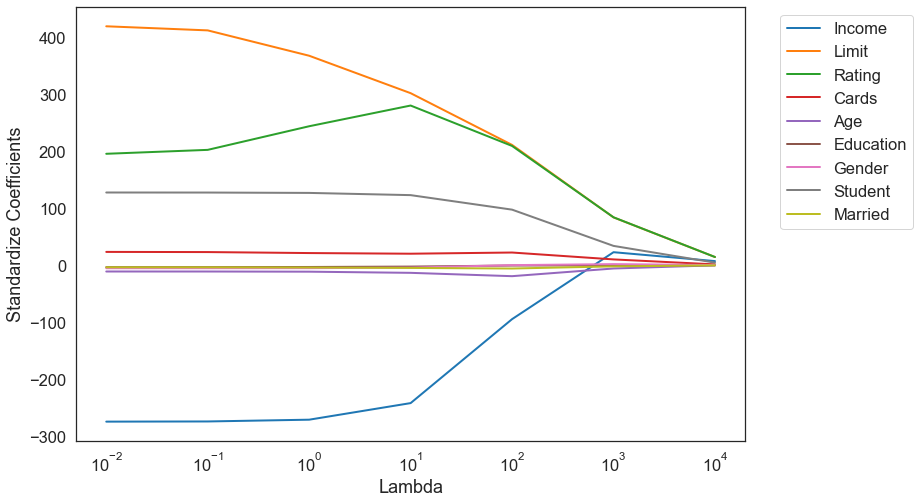

In [36]:
fig, ax = plt.subplots(figsize=(12, 8));
sns.lineplot(ax=ax, y='Standardize Coefficients', x='Lambda', hue='Feature', data=df)
ax.set_xscale('log')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');